# 1 Run Fin_over_Fout

In [ ]:
# reference
https://www.cosmos.esa.int/web/xmm-newton/epic-scripts
download the script as below

In [ ]:
# !! install dependencies!

sudo apt-get update
sudo apt-get install tcsh
sudo apt-get update
sudo apt-get install gawk

In [ ]:


chmod 755 Fin_over_Fout
./Fin_over_Fout m1ev m2ev pnev elo ehi keepfiles outfile
  m1ev      - MOS1 event file (N = ignore)
  m2ev      - MOS2 event file (N = ignore)
  pnev      - pn event file   (N = ignore)
  elo       - low-energy threshold  [eV] (N = use recommended default values)
  ehi       - high-energy threshold [eV] (N = use recommended default values)
  keepfiles - keep intermediate files (Y/N)
  outfile   - ouput file name (N = just output to screen)

# example
./Fin_over_Fout myM1ev.fits myM2ev.fits myPNev.fits 7000 12000 Y MyFinFout.dat

In [ ]:
# save Fin_over_Fout at the outer root dir


./Fin_over_Fout myM1ev.fits myM2ev.fits myPNev.fits 7000 12000 Y MyFinFout.dat


In [ ]:
## onserver: Finout_all.py  
## onserver: Finout_all.sh

def reorder_list(input_list):
    order = ['mos1', 'mos2', 'pn']
    return sorted(input_list, key=lambda x: (order.index(x[:-4]), x[-4:]))

import os
from glob import glob

homepaths = glob('/data/yanling/XGAP-ABUN/data/alldata/XGAP/SDSSTG*')

for homepath in homepaths:
    if os.path.isdir(homepath):
        os.chdir(homepath)
        with open('FinFout.sh', 'w') as f:

            elo = 500
            ehi = 7000

            name_dir = {'mos1':'mos1*-allevc', 'mos2':'mos2*-allevc', 'pn':'pn*-allevc'}

            express = f'(PATTERN<=4)&&((FLAG & 0xb0000) == 0)&&((FLAG & 0x762a097c) == 0)&&(PI in [{elo}:{ehi}])&&(DETY in [-16510:14345])'
            plot_express = f'''imagebinning='imageSize' imagedatatype='Int32' squarepixels=yes ignorelegallimits=yes withxranges=yes withyranges=yes xcolumn='X' ximagesize=900 ximagemax=48400 ximagemin=3401 ycolumn='Y' yimagesize=900 yimagemax=48400 yimagemin=3401'''

            name_lst = []
            prefix_lst = ''
            for file in glob(f'*0*-allevc.fits'):
                prefix = file.split('-')[0]
                name_lst.append(prefix)
            name_lst = reorder_list(name_lst)
            f.write(f'cp ../Fin_over_Fout .\n')
            f.write(f'chmod 755 Fin_over_Fout\n')
            f.write(f'./Fin_over_Fout {name_lst[0]}-allevc.fits {name_lst[1]}-allevc.fits {name_lst[2]}-allevc.fits 7000 12000 Y MyFinFout.dat')

            # f.write(f'''combimage prefixlist="{prefix_lst}" withcheese=no elowlist={elo} ehighlist={ehi} > -a combimg.log 2>&1 \n''')
            # f.write(f'''mv comb-fovimsky-{elo}-{ehi}.fits comb-fovimsky-{elo}-{ehi}_unmasked.fits\n''')
            # f.write(f'''mv comb-expimsky-{elo}-{ehi}.fits comb-expimsky-{elo}-{ehi}_unmasked.fits\n''')
            


# 2 Compare the SPF in FinFout with results in MyFinFout.dat
make a table about it 

In [ ]:
# on server: gen_Fin-Fout_csv.py

import os
from glob import glob
import pandas as pd

homepaths = glob('/data/yanling/XGAP-ABUN/data/alldata/XGAP/SDSSTG*')
for inst_i, inst in enumerate(['M1', 'M2', 'PN']):
    output_dict = {'ID': [], 'Fin/Fout(7-12keV)': [], 'Fin/Fout-status': [], 'SPF-fitnorm':[], 'BKG-fitting':[]}

    for homepath in homepaths:
        print(homepath)
        # read MyFinFout.dat in every subdir and read ID
        id  = homepath.split('/')[-1]
        output_dict['ID'].append(id)
        output_dict['BKG-fitting'].append('uncheck')

        # read FinFout ratio
        df = pd.read_table(f'{homepath}/MyFinFout.dat', skiprows=2, sep='\s+', header=None)

        # Extract relevant information
        exptime = float(df.iloc[inst_i, 3])
        ratio = float(df.iloc[inst_i, 5])
        status = df.iloc[inst_i, -5]

        # Print the extracted values
        print("Exposure Time:", exptime)
        print("Ratio:", ratio)
        print("Status:", status)

        output_dict['Fin/Fout(7-12keV)'].append(ratio)
        output_dict['Fin/Fout-status'].append(status)

        # read SPF fitting norm
        logfile = f'{homepath}/fit_231115/logs/bkg_bkg_freepar.log'
        with open(logfile) as logf:
            lines = logf.readlines()
            for i, line in enumerate(lines):
                if 'M' in inst:
                    if f'Model {inst.lower()}_bg' in line:
                        norm_line = lines[i+4].split()
                        print(norm_line)

                        output_dict['SPF-fitnorm'].append(float(norm_line[-3]))
                elif 'PN' in inst:
                    if f'Model {inst.lower()}_bg1' in line:
                        norm_line = lines[i+4].split()

                        output_dict['SPF-fitnorm'].append(float(norm_line[-3]))

    print(output_dict)
    df = pd.DataFrame(output_dict)
    
    df.to_csv(f'{homepath}/../dats/Fin-Fout-{inst}.csv')




# 3 visualize and compare the results of FinFout ratio and the SPF norm

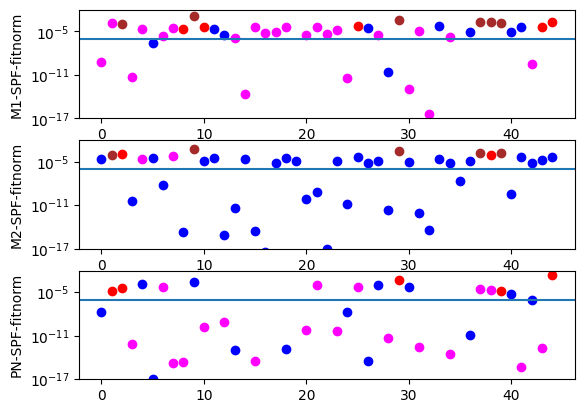

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

datpath = f'/Users/eusracenorth/Documents/work/XGAP-ABUN/alldata/dats'

fig, ax = plt.subplots(3,1)
for inst_i, inst in enumerate(['M1', 'M2', 'PN']):
    # read the table
    df = pd.read_csv(f'{datpath}/Fin-Fout-{inst}.csv')

    for i in range(len(df['SPF-fitnorm'])):
        if df['Fin/Fout-status'][i] == 'not':
            ax[inst_i].scatter(i,df['SPF-fitnorm'][i], c = 'b')
        elif df['Fin/Fout-status'][i] == 'very':
            ax[inst_i].scatter(i,df['SPF-fitnorm'][i], c = 'r')
        elif df['Fin/Fout-status'][i] == 'slightly':
            ax[inst_i].scatter(i,df['SPF-fitnorm'][i], c = 'magenta')
        elif df['Fin/Fout-status'][i] == 'extremely':
            ax[inst_i].scatter(i,df['SPF-fitnorm'][i], c = 'brown')
        else:
            print(df['Fin/Fout-status'][i])
            raise ValueError('Wrong Fin/Fout-status key!')
            
    ax[inst_i].set_ylabel(f'{inst}-SPF-fitnorm')
    ax[inst_i].set_yscale('log')
    ax[inst_i].set_ylim(1e-17, 1e-2)
    ax[inst_i].axhline(1e-6)


